## Assignment 02
### Name :-  ADIKARI A.M.A.D
### Index No :-   190021A    

In [2]:
# import libraries
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
import cv2 as cv

## Question 01

In [2]:
# function for detecting inlier points
def inliers(points, center,  r, thresh_dis):
    low_thresh, high_thresh = r-thresh_dis, r+thresh_dis   # threshold range
    dis = np.sqrt((points[:, 0]-center[0])**2+(points[:, 1]-center[1])**2)  # calculate the distance from center to points
    indices = [i for i in range(0, len(points)) if low_thresh<=abs(dis[i])<=high_thresh]        # indices of inlier points
    inl = np.array([list(points[i]) for i in indices])      # inlier points
    return inl

In [3]:
# function for getting points of circles
def circle_points(center, r):
    theta = np.linspace(0, 2*np.pi, 100)
    # cordinate points of the circle
    x = center[0] + r*np.cos(theta)
    y = center[1] + r*np.sin(theta)
    return (x, y)

In [4]:
# function for calculating the mean absolute error
def mean_absolute_error(points, center, r):
    g, f = center[0], center[1]
    dis = np.sqrt((points[:, 0]-g)**2+(points[:, 1]-f)**2)
    error = np.sum(abs(dis-r))/len(points)
    return error

In [5]:
# function for finding best RANSAC fitting with maximum inlier count
def best_RANSAC(ran):
    max_inl_count = 0
    best_ran = [[[], []], [[], []], [], [], [[], []]]
    for i in range(0, len(ran[0][0])):
        if max_inl_count<len(ran[2][i]):
            max_inl_count = len(ran[2][i])  # maximum inlier count
            for j in range(0, 5):
                if j==2 or j==3:
                    best_ran[j] = ran[j][i]
                else:
                    best_ran[j][0] = ran[j][0][i]
                    best_ran[j][1] = ran[j][1][i]
        # if inlier counts are equal then consider the minimum mean absolute error
        elif max_inl_count==len(ran[2][i]):
            if (best_ran[3] > ran[3][i]):
                max_inl_count = len(ran[2][i])
            for j in range(0, 5):
                if j==2 or j==3:
                    best_ran[j] = ran[j][i]
                else:
                    best_ran[j][0] = ran[j][0][i]
                    best_ran[j][1] = ran[j][1][i]

    print('inlier count :',max_inl_count)
    return best_ran

In [13]:
# function for getting RANSAC circles
def RANSAC(points, iterations, inlier_count, max_thresh, cand=0):
    max_r = (abs(points[:, 0].min())+abs(points[:, 0].max()))/2+5  # max radius
    ran = [[[], []], [[], []], [], [], [[], []]]    #format : center-RANSAC, center-best, sample-RANSAC, sample-RANSAC, inliers-RANSAC, error-RANSAC, radius-RANSAC, radius-best
    for i in range(0, iterations):
        p1, p2, p3 = points[np.random.choice(points.shape[0], 3, replace=False), :]  # 3 random points
        
        # calculate the center and the radius using matrices
        A = np.array([[2*p1[0], 2*p1[1], 1], [2*p2[0], 2*p2[1], 1], [2*p3[0], 2*p3[1], 1]])
        B = np.array([[p1[0]**2+p1[1]**2], [p2[0]**2+p2[1]**2], [p3[0]**2+p3[1]**2]])
        res = np.linalg.pinv(A) @ B
        g, f = res[0][0], res[1][0]
        r = np.sqrt(res[2]+g**2+f**2)
        # valid radius (below the max radius)
        if (r[0]>max_r):
            continue
        inlier_points = inliers(points, (g, f), r, max_thresh) # inlier points

        # check that inlier counts are greater than or equal to the threshold value
        if (inlier_count<=len(inlier_points)):
            # cand=1 : new candidate circle for a higher accuracy
            if (cand==1):
                # RANSAC circle datas
                ran[0][0].append((g,f))
                ran[1][0].append(np.array([[p1[0], p1[1]], [p2[0], p2[1]], [p3[0], p3[1]]]))
                ran[2].append(inlier_points)
                error = mean_absolute_error(inlier_points, (g, f), r)
                ran[3].append(error)
                ran[4][0].append(r)
            # cand = 0 : first candidate circle for the selected random sample
            if (cand==0):
                # datas for the best sample
                ran[0][1].append((g, f))
                ran[1][1].append(np.array([[p1[0], p1[1]], [p2[0], p2[1]], [p3[0], p3[1]]]))               
                ran[4][1].append(r)
                ran2 = RANSAC(inlier_points, iterations, inlier_count, max_thresh, 1)
                for i in range(0, len(ran2[0][0])):
                    ran[0][0].append(ran2[0][0][i])
                    ran[0][1].append((g, f))
                    ran[1][0].append(ran2[1][0][i])
                    ran[1][1].append(np.array([[p1[0], p1[1]], [p2[0], p2[1]], [p3[0], p3[1]]]))
                    ran[2].append(ran2[2][i])
                    ran[3].append(ran2[3][i])
                    ran[4][0].append(ran2[4][0][i])
                    ran[4][1].append(r)
    return ran


inlier count : 51


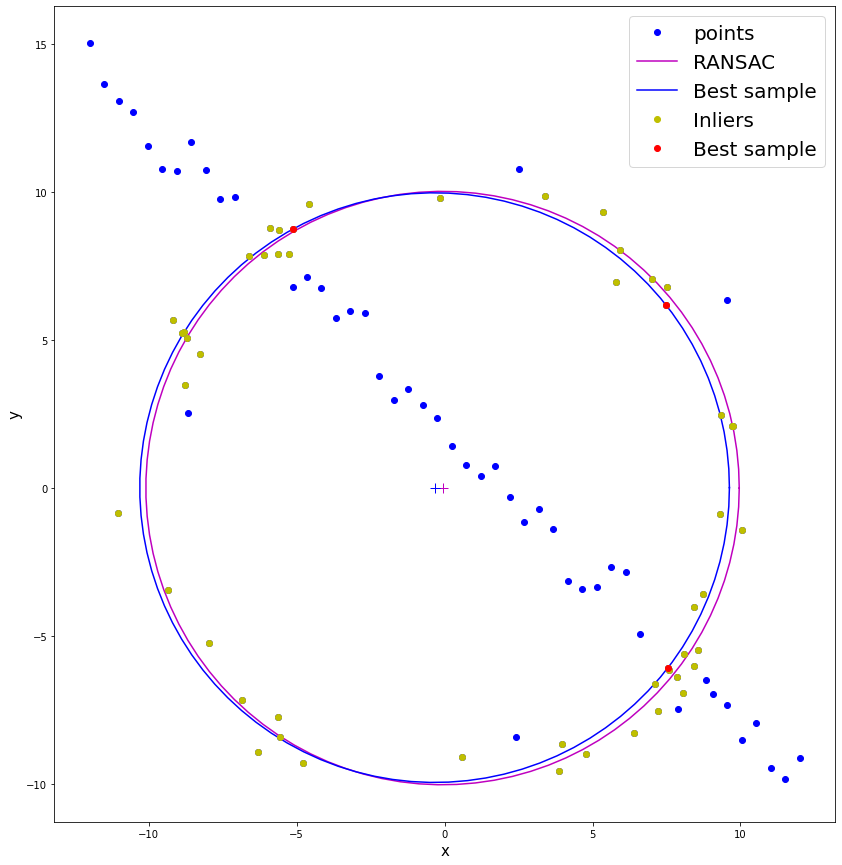

In [18]:
# sample points
# np . random . seed ( 0 )
N = 100
half_n = N// 2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r + n)*np.cos(t), (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

X = X[np.argsort(X[:, 0])] # sort


s = 3       # points for a sample
e = 0.6     # outlier ratio
p = 0.99    # probability of success
ite = int (np.log(1-p)/np.log(1-(1-e)**s)) # no. of iterations
thresh = 1  # distance threshold
inliers_count = N*(1-e) # inliers count for a circle

# getting RANSAC and best circle fitting
data = RANSAC(X, ite, inliers_count, thresh)
best_ran = best_RANSAC(data)

center_ran, center_best = best_ran[0][0], best_ran[0][1]
sample_ran, sample_best = best_ran[1][0], best_ran[1][1]
inlier_points = best_ran[2]
error = best_ran[3]
r_ran, r_best = best_ran[4][0], best_ran[4][1]
circle_ran = circle_points(center_ran, r_ran)
circle_best = circle_points(center_best, r_best)

fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(X[:, 0], X[:, 1], 'bo', label='points')
ax.plot(center_ran[0], center_ran[1], 'm+', markersize=10)
ax.plot(circle_ran[0], circle_ran[1], 'm', label='RANSAC')
ax.plot(center_best[0], center_best[1], 'b+', markersize=10)
ax.plot(circle_best[0], circle_best[1], 'b', label='Best sample')
ax.plot(inlier_points[:, 0], inlier_points[:, 1], 'yo', label='Inliers')
ax.plot(sample_best[:, 0], sample_best[:, 1], 'ro', label='Best sample')
ax.set_aspect('equal')
ax.legend(loc='best', fontsize=20)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15)

plt.show()

## Question 02

In [10]:
# function for getting coordiantes of clicked points
def mouse_click(event, x, y, flags, params):
    global counter
    # check if the left button of the mouse is clicked
    if event == cv.EVENT_LBUTTONDOWN:
        clicked_points[counter] = (x,y)
        counter += 1

In [9]:
def mousePoints(img):
    while True:
        for i in range(0, 4):
            # show a circled on clicked points
            cv.circle(img, (clicked_points[i][0], clicked_points[i][1]), 2, (0, 0, 255), cv.FILLED)
        
        if counter==4:
            cv.destroyAllWindows()
            break
        
        # showing the image
        cv.imshow('image', img)
        cv.setMouseCallback('image', mouse_click)
        cv.waitKey(1)

In [30]:
def warpAndBlend(img1, img2, alpha, beta, gamma):
    global counter
    global clicked_points
    clicked_points = np.array([(0, 0), (0, 0), (0, 0), (0, 0)]) # format : left_top, right_top, right_bottom, left_bottom
    counter=0
    img1 = cv.resize(img1, (1500, 900))
    # click points on the img1 image
    counter = 0

    img1_copy = img1.copy()
    mousePoints(img1_copy)

    # color converting
    img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
    img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

    img2_points = np.array([(0, 0), (img2.shape[1], 0), (img2.shape[1], img2.shape[0]), (0, img2.shape[0])])   # corner points of the img2

    h, status = cv.findHomography(img2_points, clicked_points)              # homography
    output_img = cv.warpPerspective(img2, h, (img1.shape[1], img1.shape[0]))        # warping img2 into img1
    blend_img = cv.addWeighted(img1, alpha, output_img, beta, gamma)           # blending img2 into img1

    fig, ax = plt.subplots(1, 2, figsize=(15, 8))
    ax[0].imshow(img1)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('main image', color='white')

    ax[1].imshow(img2)
    #ax[0][1].plot(img2_points[:, 0], img2_points[:, 1], 'go')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('warping image', color='white')

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(output_img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Warped image', color='white')

    fig, ax = plt.subplots(figsize=(25, 15))
    ax.imshow(blend_img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Blended image', color='white')

    plt.show()

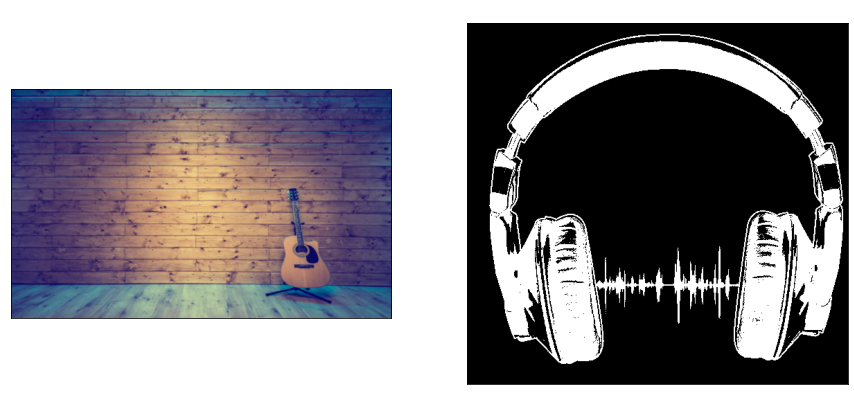

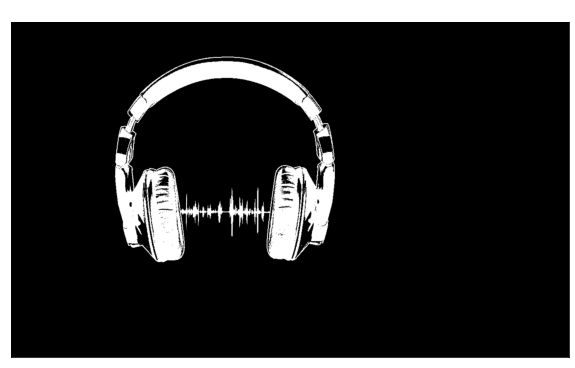

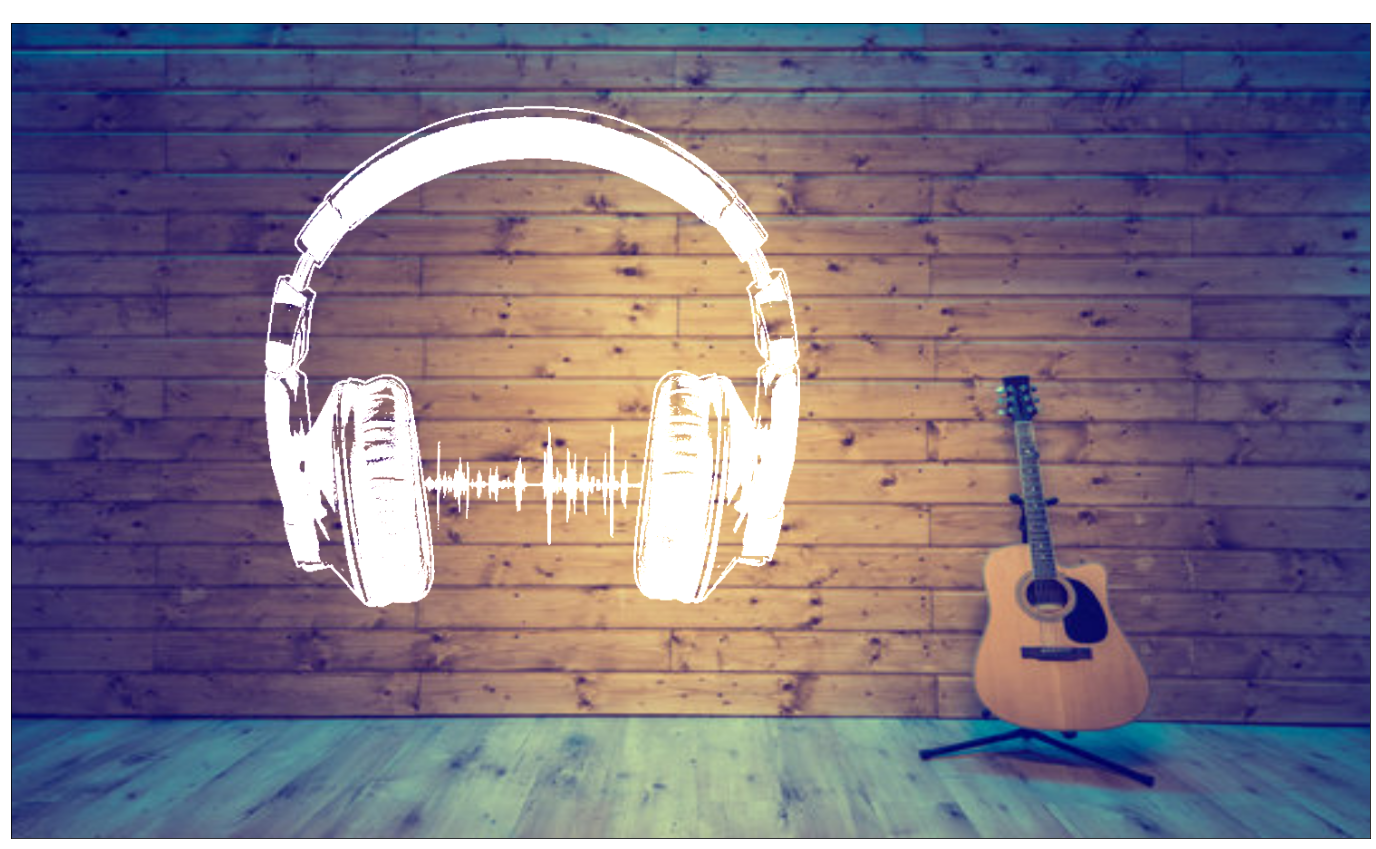

In [29]:
# # reading the images
# building = cv.imread('./Q2_images/001.jpg')
# flag = cv.imread('./Q2_images/flag.png')
# assert building is not None
# assert flag is not None
# warpAndBlend(building, flag, 1, 0.8, 0)

# car = cv.imread("C:/Users/Dulanjana/Downloads/ferrari-488-white-8k-s0.jpg")
# logo = cv.imread("C:/Users/Dulanjana/Downloads/posters-black-horse-silhouette-16.jpg.jpg")
# color = [200, 0, 0]
# mask = cv.inRange(logo, np.array([0, 0, 0]), np.array([150, 150, 150]))
# logo[mask>0] = color[::-1]
# logo[mask==0] = 0
# warpAndBlend(car, logo, 0.7, 0.3, 0)

wall = cv.imread("C:/Users/Dulanjana/Downloads/360_F_214725735_5gX5HkwCV9nYNehxcDXbz1EJCueNQrwM.jpg")
headset = cv.imread("C:/Users/Dulanjana/Downloads/headset.jpg")
mask = cv.inRange(headset, np.array([0, 0, 0]), np.array([127, 127, 127]))
headset[mask>0] = 255
headset[mask==0] = 0
warpAndBlend(wall, headset, 1, 1, 0)

## Question 03

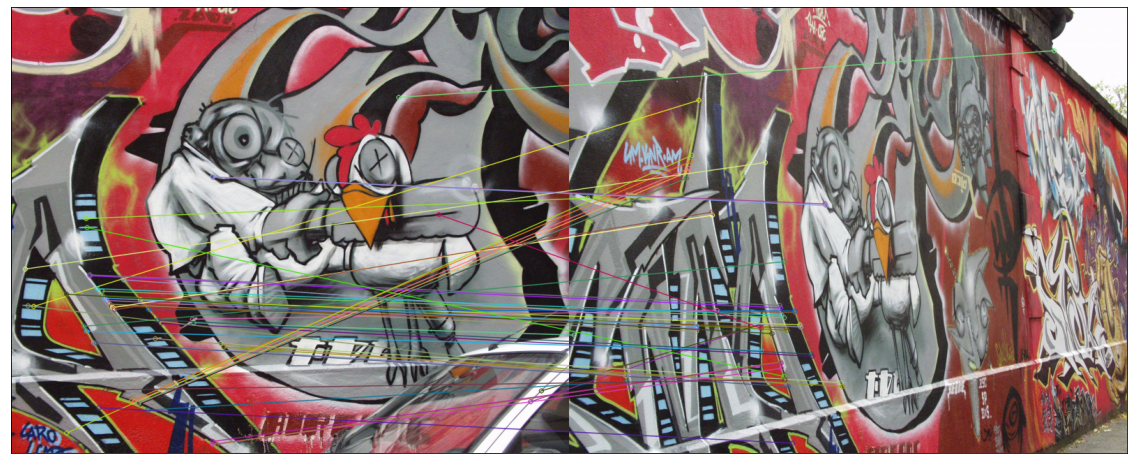

In [159]:
img1 = cv.imread('./Q3_images/img1.ppm')
img5 = cv.imread('./Q3_images/img5.ppm')
assert img1 is not None
assert img5 is not None

# img5 = img5[:, 200:600, :]

img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create(nOctaveLayers = 3, contrastThreshold = 0.1, edgeThreshold = 25, sigma = 1)
bf = cv.BFMatcher(cv.NORM_L2SQR, crossCheck=True)

key1, des1 = sift.detectAndCompute(img1_gray, None)
key5, des5 = sift.detectAndCompute(img5_gray, None)

matches = bf.match(des1, des5)
matches = sorted(matches, key=lambda x:x.distance)

out_img = cv.drawMatches(img1, key1, img5, key5, matches[:50], img5, flags=2)

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(out_img)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [33]:
def matched_coordinates(matches, key1, key2):
    p1, p2 = [], []
    for match in matches:
        k1_index = match.queryIdx
        k2_index = match.trainIdx
        point1 = key1[k1_index].pt
        point2 = key2[k2_index].pt
        p1.append(point1)
        p2.append(point2)
    return np.array(p1, dtype=np.float32), np.array(p2, dtype=np.float32)

In [21]:
def inliers(H, points1, points2, thresh_dis):
    count = 0
    inl = []
    for i in range(0, len(matches)):
        B = np.array([[points2[i][0]], [points2[i][1]], [1]])
        A = np.array(H) @ B
        Ax, Ay = A[0][0]/A[-1][0], A[1][0]/A[-1][0]
        Px, Py = points1[i][0], points1[i][1]
        #print(Ax, Ay, Px, Py)
        if (np.sqrt((Ax-Px)**2 + (Ay-Py)**2)<=thresh_dis):
            count += 1          
            inl.append(i)
    return [count-4, inl]
    

In [164]:
def RANSAC(matches, key1, key2,  iterations, thresh_dis):
    best_points = [[], []]
    max_inliers = 0
    indices = []
    best_H = []
    points1, points2 = matched_coordinates(matches, key1, key5)
    for i in range(0, iterations):
        k1, k2, k3, k4 = np.random.randint(0, len(matches)-1, 4)
        q_index1, t_index1 = matches[k1].queryIdx, matches[k1].trainIdx
        point_q1, point_t1 = key1[q_index1].pt, key2[t_index1].pt
        q_index2, t_index2 = matches[k2].queryIdx, matches[k2].trainIdx
        point_q2, point_t2 = key1[q_index2].pt, key2[t_index2].pt
        q_index3, t_index3 = matches[k3].queryIdx, matches[k3].trainIdx
        point_q3, point_t3 = key1[q_index3].pt, key2[t_index3].pt
        q_index4, t_index4 = matches[k4].queryIdx, matches[k4].trainIdx
        point_q4, point_t4 = key1[q_index4].pt, key2[t_index4].pt

        q_points = [point_q1, point_q2, point_q3, point_q4]
        t_points = [point_t1, point_t2, point_t3, point_t4]

        colinear =  bool(np.cross(point_q1, point_q2)) and bool(np.cross(point_q2, point_q3)) and bool(np.cross(point_q3, point_q4))
        colinear =  colinear and bool(np.cross(point_q2, point_q3)) and bool(np.cross(point_q2, point_q4))
        colinear =  colinear and bool(np.cross(point_q3, point_q4))
        if (not colinear):
            continue

        A = []
        for i in range(0, 5):
            if i!=4:
                A.append([-t_points[i][0], -t_points[i][1], -1, 0, 0, 0, t_points[i][0]*q_points[i][0], t_points[i][1]*q_points[i][0], q_points[i][0]])
                A.append([0, 0, 0, -t_points[i][0], -t_points[i][1], -1, t_points[i][0]*q_points[i][1], t_points[i][1]*q_points[i][1], q_points[i][1]])
            else:
                A.append([0, 0, 0, 0, 0, 0, 0, 0, 1])
        A = np.array(A)
        B = np.array([[0], [0], [0], [0], [0], [0], [0], [0], [1]])

        h = np.linalg.inv(A.T @ A) @ A.T @ B
        H = [[], [], []]
        for i in range(0, 9):
            H[i//3].append(h[i][0])

        inliers_n, ind = inliers(H, points1, points2, thresh_dis)
        if inliers_n>max_inliers:        
            best_points[0] = [point_q1, point_q2, point_q3, point_q4]
            best_points[1] = [point_t1, point_t2, point_t3, point_t4]
            max_inliers=inliers_n
            best_H = H
            indices = ind

    print(max_inliers, len(indices))
    return best_H, [np.array(best_points[0], dtype=np.float32), np.array(best_points[1], dtype=np.float32)], indices

4 8
653


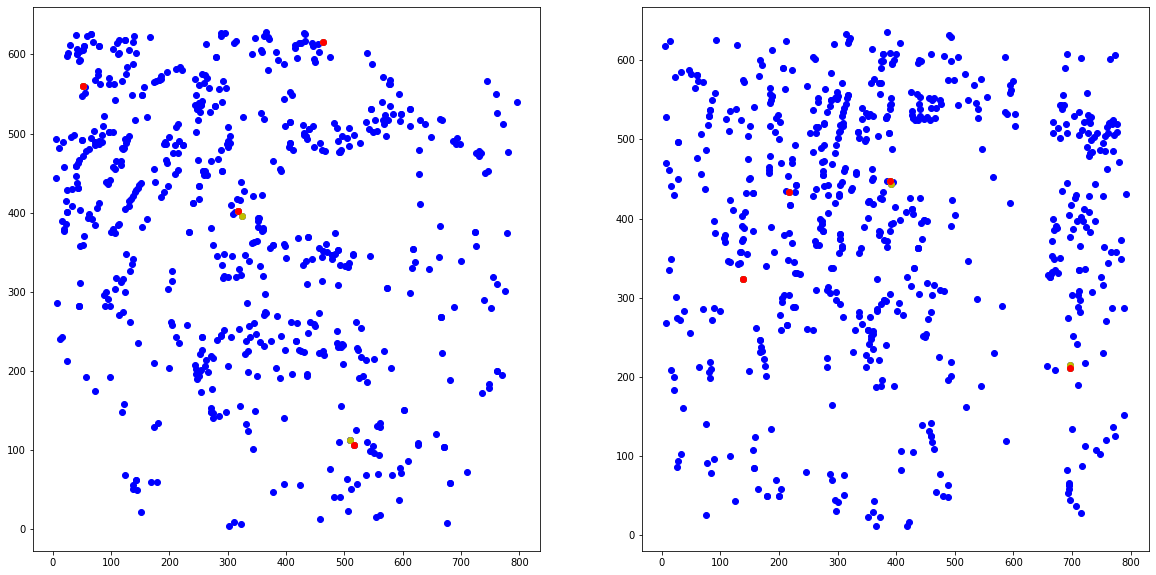

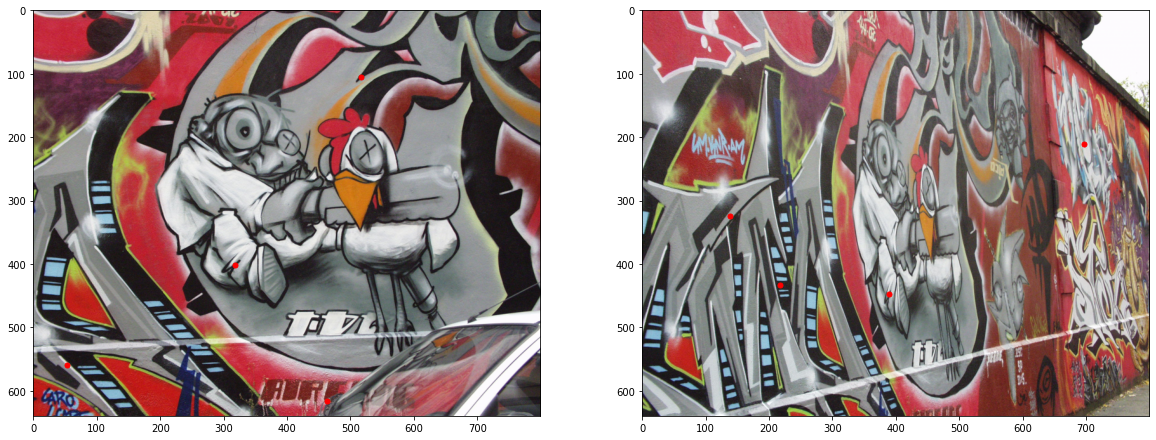

In [165]:
points1, points2 = matched_coordinates(matches, key1, key5)

H, p, indices = RANSAC(matches, key1, key5, 200, 2.5)
inliers1, inliers2 = points1[indices], points2[indices]
print(len(matches))
img1_h_points, img2_h_points = p[0], p[1] 


fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(points1[:, 0], points1[:, 1], 'bo')
ax[0].plot(inliers1[:, 0], inliers1[:, 1], 'yo')
ax[0].plot(img1_h_points[:, 0], img1_h_points[:, 1], 'ro')

ax[1].plot(points2[:, 0], points2[:, 1], 'bo')
ax[1].plot(inliers2[:, 0], inliers2[:, 1], 'yo')
ax[1].plot(img2_h_points[:, 0], img2_h_points[:, 1], 'ro')

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img1)
ax[0].plot(img1_h_points[:, 0], img1_h_points[:, 1], 'ro', markersize=5)

ax[1].imshow(img5)
ax[1].plot(img2_h_points[:, 0], img2_h_points[:, 1], 'ro', markersize=5)

plt.show()

[[0.7358687557546959, -13.599674717120797, 5596.784749495946], [7.938955746364081, -9.510010202767965, 161.02964802732672], [0.02254378008493051, -0.026098103358058115, 1.0000000047097948]]


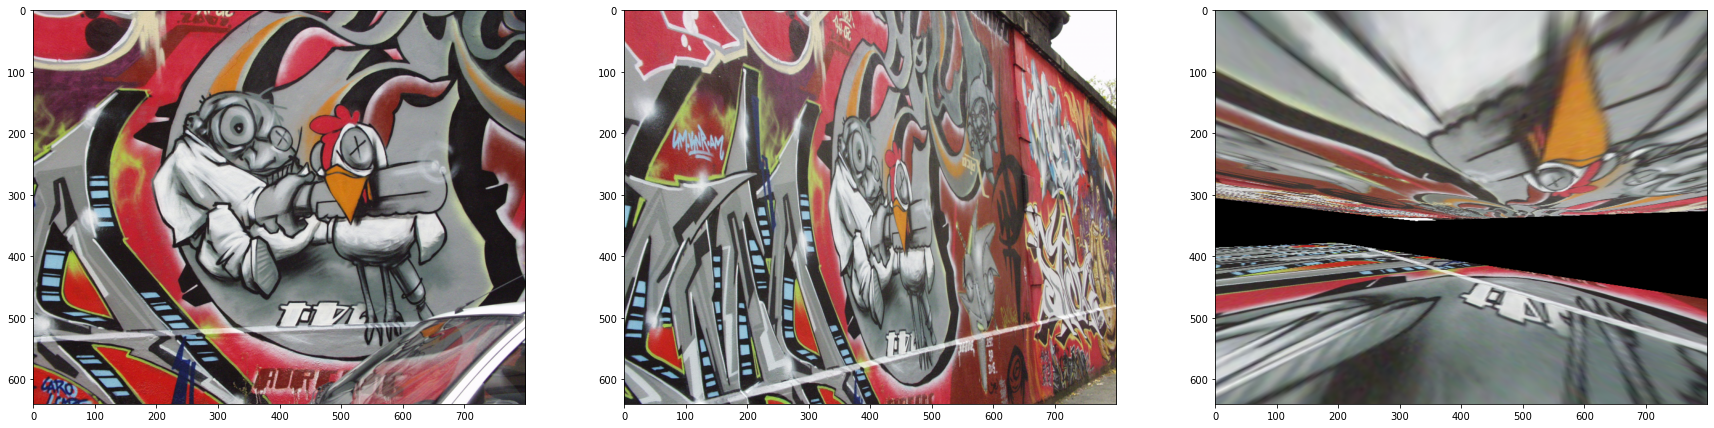

In [157]:
print(H)

out_img = cv.warpPerspective(img5, np.array(H), (img1.shape[1], img1.shape[0]))

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(img1)
ax[1].imshow(img5)
ax[2].imshow(out_img)

plt.show()